In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

In [25]:
df = pd.read_csv(r"C:\Users\hp\Downloads\Dataset_Uber Traffic.csv" , parse_dates=['DateTime'])


In [28]:
print("Dataset Info:")
print(df.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
 3   ID        48120 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.5 MB
None


In [29]:
print("\nFirst 5 rows:")
print(df.head())
print("\nSummary Statistics:")
print(df.describe())


First 5 rows:
             DateTime  Junction  Vehicles           ID
0 2015-01-11 00:00:00         1        15  20151101001
1 2015-01-11 01:00:00         1        13  20151101011
2 2015-01-11 02:00:00         1        10  20151101021
3 2015-01-11 03:00:00         1         7  20151101031
4 2015-01-11 04:00:00         1         9  20151101041

Summary Statistics:
                            DateTime      Junction      Vehicles            ID
count                          48120  48120.000000  48120.000000  4.812000e+04
mean   2016-09-26 15:27:43.541147136      2.180549     22.791334  2.016330e+10
min              2015-01-11 00:00:00      1.000000      1.000000  2.015110e+10
25%              2016-04-16 01:45:00      1.000000      9.000000  2.016042e+10
50%              2016-09-30 03:30:00      2.000000     15.000000  2.016093e+10
75%              2017-03-15 16:00:00      3.000000     29.000000  2.017023e+10
max              2017-12-06 23:00:00      4.000000    180.000000  2.017063e+10
st

In [30]:
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64


In [36]:
df['Hour'] = df['DateTime'].dt.hour
df['DayOfWeek'] = df['DateTime'].dt.dayofweek  # Monday=0, Sunday=6
df['Month'] = df['DateTime'].dt.month
df['Day'] = df['DateTime'].dt.day

Text(0.5, 1.0, 'Traffic by Hour')

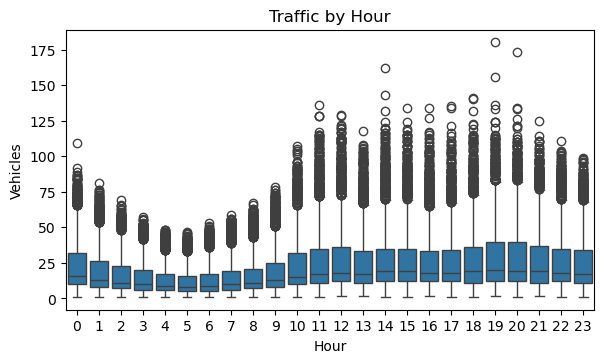

In [38]:
plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
sns.boxplot(x='Hour', y='Vehicles', data=df)
plt.title('Traffic by Hour')

Text(0.5, 1.0, 'Traffic by Day of Week')

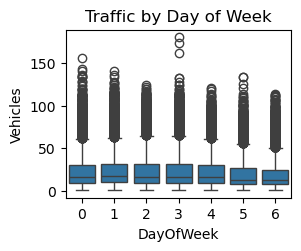

In [40]:
plt.subplot(2, 2, 2)
sns.boxplot(x='DayOfWeek', y='Vehicles', data=df)
plt.title('Traffic by Day of Week')

Text(0.5, 1.0, 'Traffic by Month')

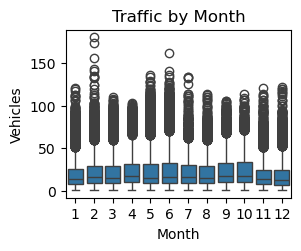

In [42]:
plt.subplot(2, 2, 3)
sns.boxplot(x='Month', y='Vehicles', data=df)
plt.title('Traffic by Month')

In [44]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [46]:
df['Vehicles_lag1'] = df['Vehicles'].shift(1)
df['Vehicles_lag2'] = df['Vehicles'].shift(2)
df['Vehicles_lag3'] = df['Vehicles'].shift(3)
df['Vehicles_lag24'] = df['Vehicles'].shift(24)

In [48]:
df = df.dropna()

In [50]:
X = df[['Hour', 'DayOfWeek', 'Month', 'Day', 'Vehicles_lag1', 'Vehicles_lag2', 'Vehicles_lag3', 'Vehicles_lag24']]
y = df['Vehicles']

In [52]:
# Time-based split (80% train, 20% test)
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 38476
Test set size: 9620


In [54]:
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [56]:
y_pred_gbr = gbr.predict(X_test)

In [58]:
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
print(f"Gradient Boosting Results:")
print(f"MAE: {mae_gbr:.2f}")
print(f"MSE: {mse_gbr:.2f}")

Gradient Boosting Results:
MAE: 2.60
MSE: 22.98


In [64]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': gbr.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)


Feature Importance:
          Feature  Importance
4   Vehicles_lag1    0.951160
7  Vehicles_lag24    0.029365
0            Hour    0.013403
5   Vehicles_lag2    0.003887
6   Vehicles_lag3    0.001600
1       DayOfWeek    0.000397
3             Day    0.000108
2           Month    0.000081


In [62]:
# Prepare data for ARIMA (just the time series)
ts_data = df.set_index('DateTime')['Vehicles']

In [66]:
train_size = int(len(ts_data) * 0.8)
train, test = ts_data[:train_size], ts_data[train_size:]

In [72]:
model_arima = ARIMA(train, order=(5,1,0))  # (p,d,q)
model_fit = model_arima.fit()

In [73]:
y_pred_arima = model_fit.forecast(steps=len(test))

In [74]:
mae_arima = mean_absolute_error(test, y_pred_arima)
mse_arima = mean_squared_error(test, y_pred_arima)
print("\nARIMA Results:")
print(f"MAE: {mae_arima:.2f}")
print(f"MSE: {mse_arima:.2f}")


ARIMA Results:
MAE: 7.38
MSE: 144.18


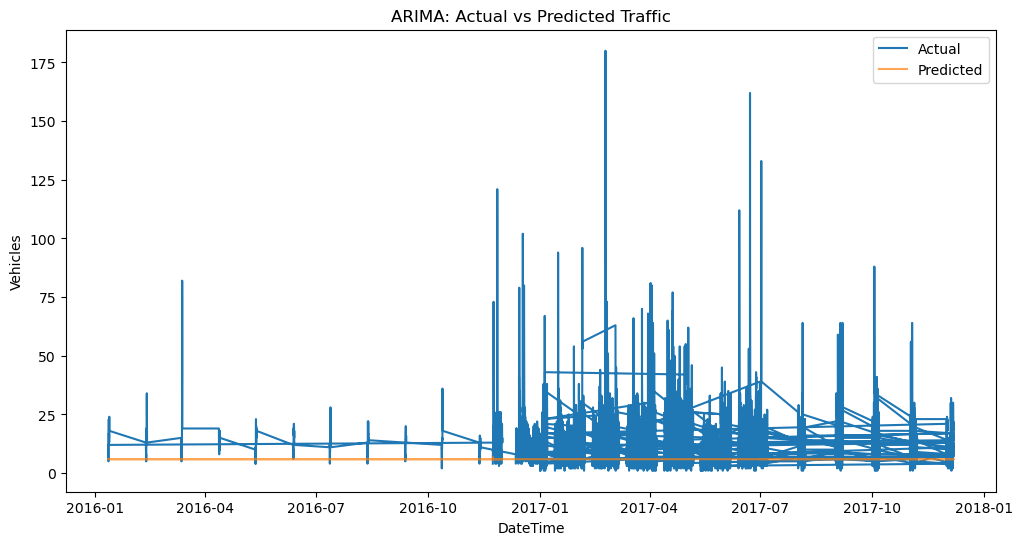

In [78]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, y_pred_arima, label='Predicted', alpha=0.7)
plt.title('ARIMA: Actual vs Predicted Traffic')
plt.xlabel('DateTime')
plt.ylabel('Vehicles')
plt.legend()
plt.show()

In [80]:
# Prepare data for LSTM
def create_dataset(data, look_back=1):
    X, y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back), 0])
        y.append(data[i+look_back, 0])
    return np.array(X), np.array(y)

In [82]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(ts_data.values.reshape(-1, 1))

In [84]:
# Create training and test sets
look_back = 24  # Using 24 hours as lookback
train_size = int(len(scaled_data) * 0.8)
train, test = scaled_data[:train_size], scaled_data[train_size:]

X_train_lstm, y_train_lstm = create_dataset(train, look_back)
X_test_lstm, y_test_lstm = create_dataset(test, look_back)

In [86]:
X_train_lstm = np.reshape(X_train_lstm, (X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = np.reshape(X_test_lstm, (X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

In [88]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model_lstm.add(LSTM(50))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')

In [90]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
history = model_lstm.fit(
    X_train_lstm, y_train_lstm, 
    epochs=50, 
    batch_size=32, 
    validation_data=(X_test_lstm, y_test_lstm),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 39s 27ms/step - loss: 0.0014 - val_loss: 8.9264e-04
Epoch 2/50
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - loss: 6.5005e-04 - val_loss: 7.9458e-04
Epoch 3/50
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - loss: 6.1443e-04 - val_loss: 8.1259e-04
Epoch 4/50
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - loss: 5.9981e-04 - val_loss: 7.5960e-04
Epoch 5/50
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - loss: 5.8822e-04 - val_loss: 7.9509e-04
Epoch 6/50
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - loss: 5.7282e-04 - val_loss: 7.6400e-04
Epoch 7/50
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - loss: 5.5511e-04 - val_loss: 7.3757e-04
Epoch 8/50
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - loss: 5.4733e-04 - val_loss: 8.2376e-04
Epoch 9/50
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 33s 28ms/step - loss: 5.4506e-04 - val_loss: 7.3981e-04
Epoch 10/50
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - loss: 5.2693e-04 - val_loss: 7.4749e-04
Epoch 11/50
1202/1202 ━

In [92]:
y_pred_lstm = model_lstm.predict(X_test_lstm)

300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


In [94]:
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)
y_test_lstm = scaler.inverse_transform([y_test_lstm])

In [96]:
mae_lstm = mean_absolute_error(y_test_lstm[0], y_pred_lstm[:,0])
mse_lstm = mean_squared_error(y_test_lstm[0], y_pred_lstm[:,0])
print("\nLSTM Results:")
print(f"MAE: {mae_lstm:.2f}")
print(f"MSE: {mse_lstm:.2f}")


LSTM Results:
MAE: 2.80
MSE: 26.96


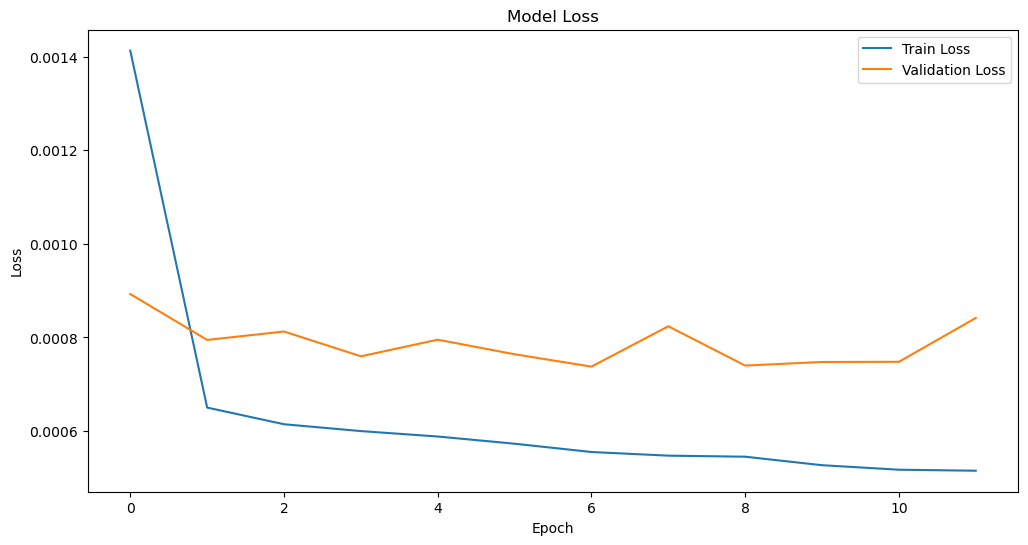

In [98]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [100]:
# Compare model performance
results = pd.DataFrame({
    'Model': ['Gradient Boosting', 'ARIMA', 'LSTM'],
    'MAE': [mae_gbr, mae_arima, mae_lstm],
    'MSE': [mse_gbr, mse_arima, mse_lstm]
})

print("\nModel Comparison:")
print(results.sort_values('MAE'))


Model Comparison:
               Model       MAE         MSE
0  Gradient Boosting  2.602204   22.981819
2               LSTM  2.799351   26.960983
1              ARIMA  7.383091  144.184838


In [102]:
from sklearn.model_selection import GridSearchCV

In [104]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

In [106]:
grid_search = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=param_grid,
    cv=TimeSeriesSplit(n_splits=3),  # Time-series cross-validation
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

In [108]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=GradientBoostingRegressor(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [50, 100, 150]},
             scoring='neg_mean_absolute_error', verbose=1)

In [110]:
print("\nBest Parameters:", grid_search.best_params_)


Best Parameters: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 50}


In [112]:
best_gbr = grid_search.best_estimator_
y_pred_best = best_gbr.predict(X_test)
mae_best = mean_absolute_error(y_test, y_pred_best)
print(f"Optimized Gradient Boosting MAE: {mae_best:.2f}")

Optimized Gradient Boosting MAE: 2.60


In [114]:
import joblib

In [116]:
final_model = GradientBoostingRegressor(
    n_estimators=grid_search.best_params_['n_estimators'],
    learning_rate=grid_search.best_params_['learning_rate'],
    max_depth=grid_search.best_params_['max_depth'],
    random_state=42
)
final_model.fit(X, y)

GradientBoostingRegressor(learning_rate=0.2, max_depth=4, n_estimators=50,
                          random_state=42)

In [118]:
joblib.dump(final_model, 'uber_traffic_model.pkl')

['uber_traffic_model.pkl']

In [120]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [122]:
def evaluate_model(y_true, y_pred, model_name):
    """Calculate and print evaluation metrics"""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{model_name} Evaluation:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R-squared: {r2:.2f}")
    
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2}

In [124]:
y_pred_gbr = gbr.predict(X_test)

In [126]:
gb_metrics = evaluate_model(y_test, y_pred_gbr, "Gradient Boosting")


Gradient Boosting Evaluation:
MAE: 2.60
RMSE: 4.79
R-squared: 0.77


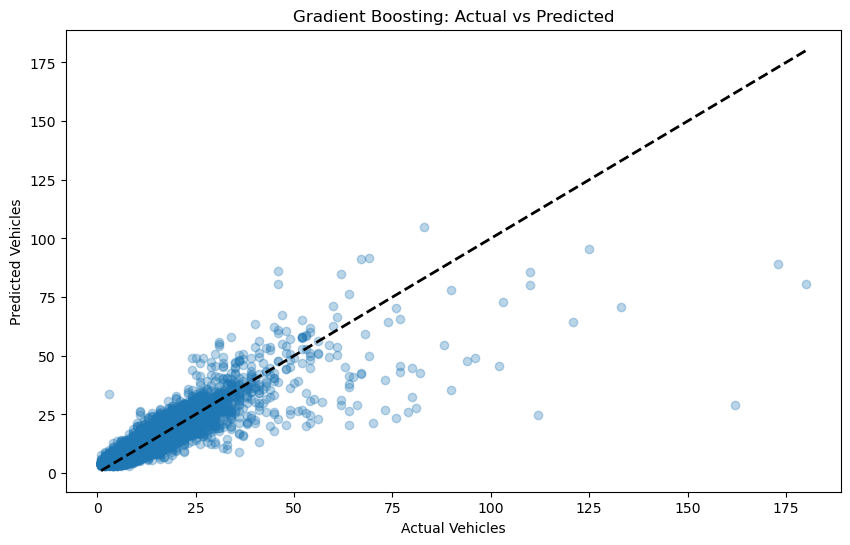

In [128]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_gbr, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Vehicles')
plt.ylabel('Predicted Vehicles')
plt.title('Gradient Boosting: Actual vs Predicted')
plt.show()

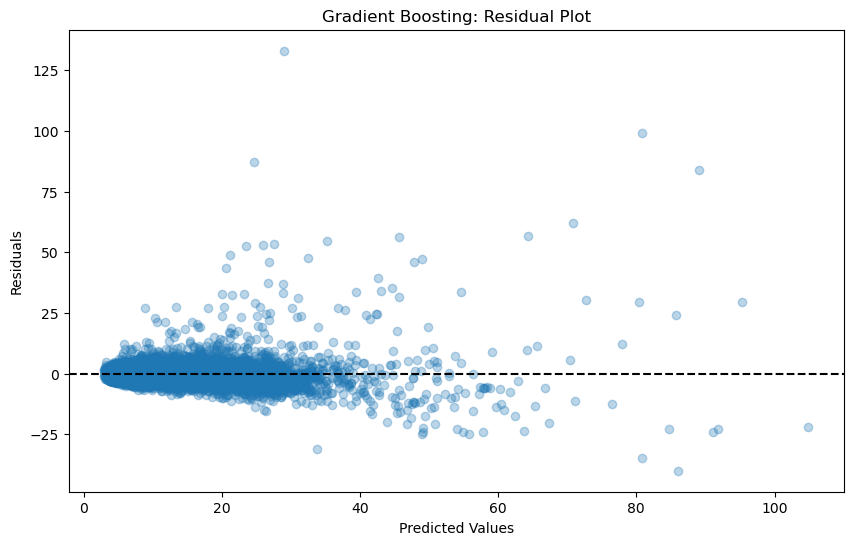

In [130]:
residuals = y_test - y_pred_gbr
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_gbr, residuals, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Gradient Boosting: Residual Plot')
plt.show()

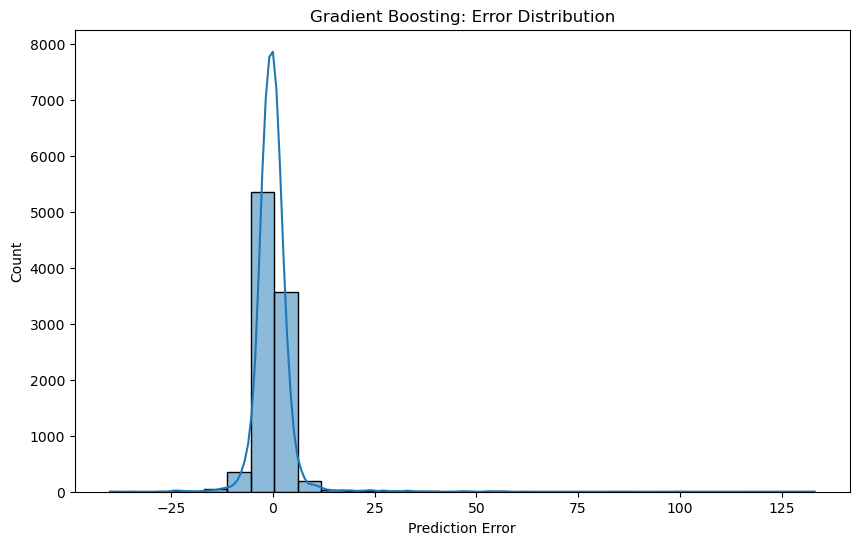

In [132]:
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Gradient Boosting: Error Distribution')
plt.xlabel('Prediction Error')
plt.show()

In [146]:
if len(test.shape) > 1:
    test = test.flatten()
if len(y_pred_arima.shape) > 1:
    y_pred_arima = y_pred_arima.flatten()

In [148]:
test_series = pd.Series(test, index=ts_data.index[-len(test):])
pred_series = pd.Series(y_pred_arima, index=ts_data.index[-len(y_pred_arima):])

In [157]:
def safe_evaluate_arima(actual, predicted):
    actual = np.array(actual)
    predicted = np.array(predicted)
    
   
    valid_mask = np.isfinite(actual) & np.isfinite(predicted)
    
    if not np.any(valid_mask):
        raise ValueError("No valid data points for evaluation")
    
    actual_valid = actual[valid_mask]
    predicted_valid = predicted[valid_mask]
    
    
    mae = mean_absolute_error(actual_valid, predicted_valid)
    rmse = np.sqrt(mean_squared_error(actual_valid, predicted_valid))
    r2 = r2_score(actual_valid, predicted_valid)
    
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R-squared: {r2:.2f}")
    print(f"Valid data points: {len(actual_valid)}/{len(actual)}")
    
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'n_valid': len(actual_valid)}

In [159]:
def prepare_arima_data():
    
    ts_data = df.set_index('DateTime')['Vehicles']
    
    
    train_size = int(len(ts_data) * 0.8)
    train, test = ts_data[:train_size], ts_data[train_size:]
    
    
    model_arima = ARIMA(train, order=(5,1,0))
    model_fit = model_arima.fit()
    
    
    y_pred_arima = model_fit.forecast(steps=len(test))
    
    
    test_values = test.values.flatten()
    pred_values = y_pred_arima.values.flatten() if hasattr(y_pred_arima, 'values') else y_pred_arima
    
    
    test_series = pd.Series(test_values, index=test.index)
    pred_series = pd.Series(pred_values, index=test.index[:len(pred_values)])
    
    return test_series, pred_series

In [161]:
print("ARIMA Evaluation Metrics:")
test_series, pred_series = prepare_arima_data()
arima_metrics = safe_evaluate_arima(test_series, pred_series)

ARIMA Evaluation Metrics:
MAE: 7.38
RMSE: 12.01
R-squared: -0.45
Valid data points: 9620/9620


In [163]:
def plot_arima_results(actual, predicted):
    """Plot ARIMA results with proper handling"""
    # Find valid data points
    valid_mask = np.isfinite(actual) & np.isfinite(predicted)
    actual_valid = actual[valid_mask]
    predicted_valid = predicted[valid_mask]
    
    # Time series plot
    plt.figure(figsize=(12, 6))
    plt.plot(actual.index, actual, label='Actual', alpha=0.7)
    plt.plot(predicted.index, predicted, label='Predicted', alpha=0.7)
    plt.title('ARIMA: Actual vs Predicted Traffic')
    plt.xlabel('Date')
    plt.ylabel('Vehicles')
    plt.legend()
    plt.show()
    
    # Scatter plot (only valid points)
    plt.figure(figsize=(10, 6))
    plt.scatter(actual_valid, predicted_valid, alpha=0.3)
    plt.plot([actual_valid.min(), actual_valid.max()], 
             [actual_valid.min(), actual_valid.max()], 'r--', lw=2)
    plt.xlabel('Actual Vehicles')
    plt.ylabel('Predicted Vehicles')
    plt.title('ARIMA: Actual vs Predicted Scatter Plot')
    plt.show()
    
    # Residual plot
    residuals = actual_valid - predicted_valid
    plt.figure(figsize=(10, 6))
    plt.scatter(predicted_valid, residuals, alpha=0.3)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('ARIMA Residual Plot')
    plt.show()
    
    # Error distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True, bins=30)
    plt.title('ARIMA Error Distribution')
    plt.xlabel('Prediction Error')
    plt.show()


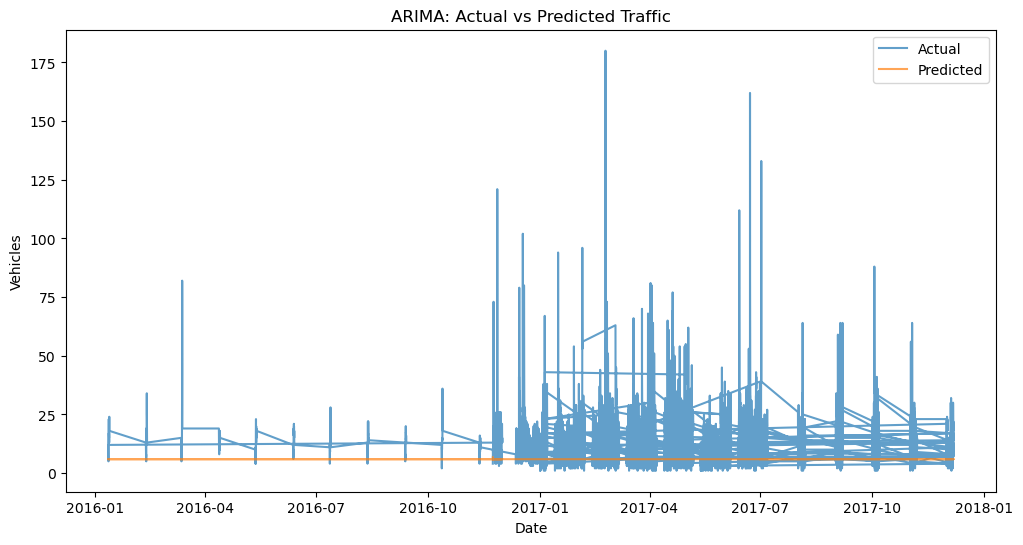

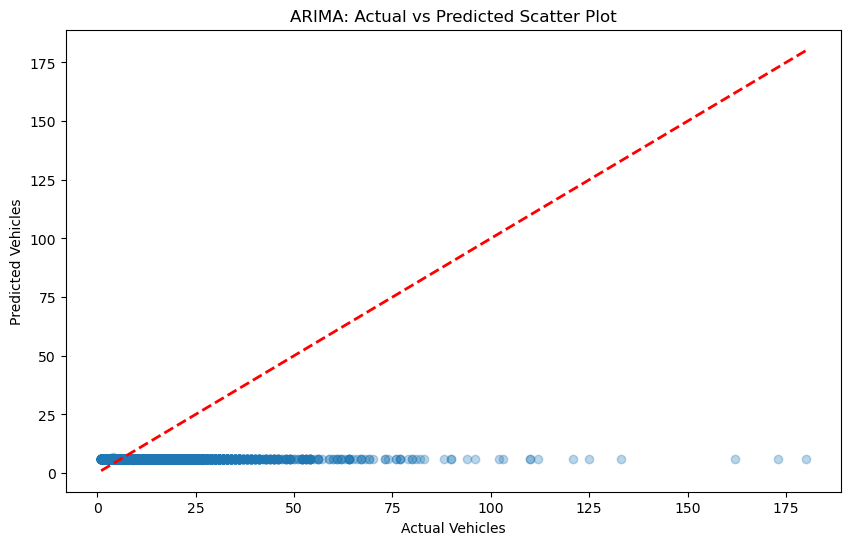

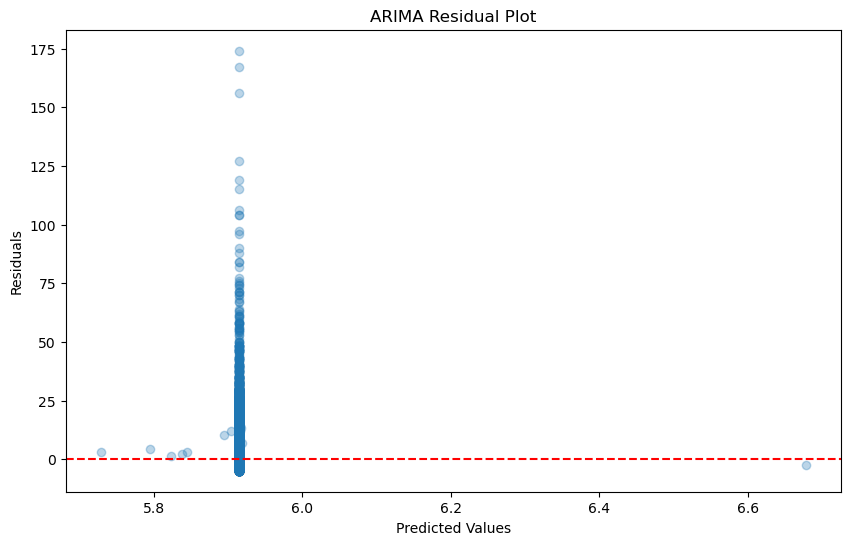

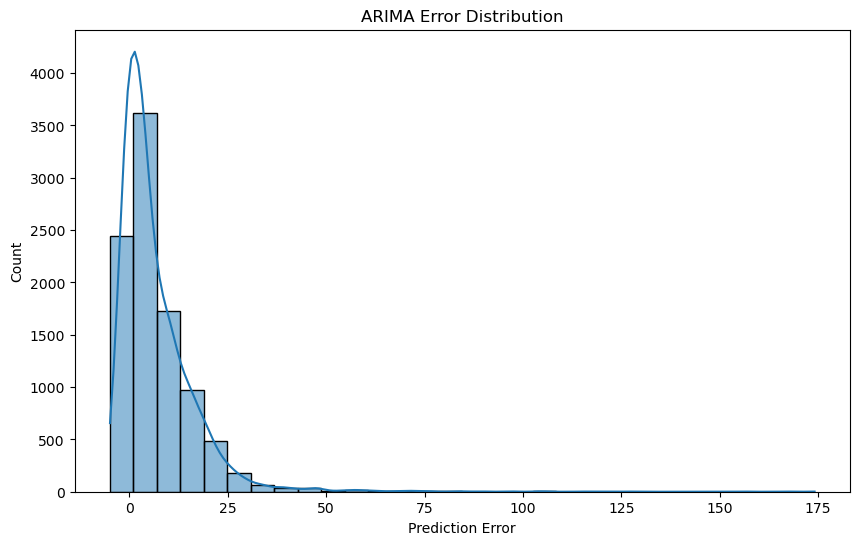

In [165]:
plot_arima_results(test_series, pred_series)

In [167]:
def arima_cross_validation(ts_data, n_splits=5, order=(5,1,0)):
    """Perform walk-forward validation for ARIMA"""
    cv_metrics = {'MAE': [], 'RMSE': [], 'R2': [], 'n_valid': []}
    
    test_size = len(ts_data) // n_splits
    
    for i in range(1, n_splits + 1):
        # Split data
        train = ts_data[:-(n_splits - i + 1) * test_size]
        test = ts_data[-(n_splits - i + 1) * test_size:][:test_size]
        
        try:
            # Fit model
            model = ARIMA(train, order=order)
            model_fit = model.fit()
            
            # Forecast
            y_pred = model_fit.forecast(steps=len(test))
            
            # Evaluate
            metrics = safe_evaluate_arima(test.values, y_pred)
            
            # Store metrics
            for key in metrics:
                if key in cv_metrics:
                    cv_metrics[key].append(metrics[key])
                    
        except Exception as e:
            print(f"Fold {i} failed: {e}")
            continue
    
    return cv_metrics

In [169]:
print("\nARIMA Cross-Validation Results:")
cv_results = arima_cross_validation(ts_data, n_splits=5)


ARIMA Cross-Validation Results:
Fold 1 failed: Schur decomposition solver error.
MAE: 56.56
RMSE: 63.63
R-squared: -3.08
Valid data points: 9619/9619
MAE: 6.20
RMSE: 7.70
R-squared: -0.07
Valid data points: 9619/9619
MAE: 6.44
RMSE: 10.18
R-squared: -0.09
Valid data points: 9619/9619
MAE: 10.02
RMSE: 14.11
R-squared: -1.00
Valid data points: 9619/9619


In [171]:
print("\nARIMA CV Summary:")
for metric, values in cv_results.items():
    if values:  # Only print if we have values
        avg = np.mean(values)
        std = np.std(values)
        print(f"{metric}: {avg:.2f} (±{std:.2f})")


ARIMA CV Summary:
MAE: 19.81 (±21.27)
RMSE: 23.90 (±23.05)
R2: -1.06 (±1.23)
n_valid: 9619.00 (±0.00)


In [173]:
from sklearn.model_selection import TimeSeriesSplit

In [175]:
tscv = TimeSeriesSplit(n_splits=5)

In [177]:
gb_cv_metrics = {'MAE': [], 'RMSE': [], 'R2': []}

In [179]:
print("Gradient Boosting Cross-Validation:")
for fold, (train_index, val_index) in enumerate(tscv.split(X)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    gbr.fit(X_train, y_train)
    y_pred = gbr.predict(X_val)
    metrics = evaluate_model(y_val, y_pred, f"Fold {fold+1}")
    for key in metrics:
        gb_cv_metrics[key].append(metrics[key])
        

Gradient Boosting Cross-Validation:

Fold 1 Evaluation:
MAE: 5.36
RMSE: 8.52
R-squared: 0.91

Fold 2 Evaluation:
MAE: 1.97
RMSE: 2.47
R-squared: 0.66

Fold 3 Evaluation:
MAE: 2.36
RMSE: 3.13
R-squared: 0.90

Fold 4 Evaluation:
MAE: 2.89
RMSE: 5.41
R-squared: 0.71

Fold 5 Evaluation:
MAE: 2.51
RMSE: 4.57
R-squared: 0.78


In [181]:
print("\nGradient Boosting CV Average Metrics:")
for metric in gb_cv_metrics:
    avg = np.mean(gb_cv_metrics[metric])
    std = np.std(gb_cv_metrics[metric])
    print(f"{metric}: {avg:.2f} (±{std:.2f})")


Gradient Boosting CV Average Metrics:
MAE: 3.02 (±1.21)
RMSE: 4.82 (±2.12)
R2: 0.79 (±0.10)


In [183]:
from statsmodels.tsa.arima.model import ARIMA

In [185]:
arima_cv_metrics = {'MAE': [], 'RMSE': [], 'R2': []}

In [187]:
print("\nARIMA Walk-Forward Validation:")
n_splits = 5
test_size = len(ts_data)


ARIMA Walk-Forward Validation:


In [189]:
for i in range(1, n_splits + 1):
    train = ts_data[:-(n_splits - i + 1) * test_size]
    test = ts_data[-(n_splits - i + 1) * test_size:][:test_size]
    model = ARIMA(train, order=(5,1,0))
    model_fit = model.fit()
    y_pred = model_fit.forecast(steps=len(test))
    metrics = evaluate_model(test, y_pred, f"Fold {i}")
    for key in metrics:
        arima_cv_metrics[key].append(metrics[key])

LinAlgError: Schur decomposition solver error.

In [ ]:
print("\nARIMA CV Average Metrics:")
for metric in arima_cv_metrics:
    avg = np.mean(arima_cv_metrics[metric])
    std = np.std(arima_cv_metrics[metric])
    print(f"{metric}: {avg:.2f} (±{std:.2f})")